In [30]:
import pandas as pd
import warnings
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [5]:
bike_trips = pd.read_csv('datasets/bike_trips.csv')
bike_trips.head()

,Unnamed: 0,index,trip_id,bike_id,trip_duration,trip_start_time,trip_end_time,from_station,from_station_id,from_station_mode,from_lat,from_long,to_station,to_station_id,to_station_mode,to_lat,to_long
0,11,998695,1001,13022,23.0,2019-03-11 16:39:41,2019-03-11 17:02:49,Karl-Marx Allee,1465,station,52.517298,13.441311,Oranienplatz,1445.0,station,52.501950,13.416246
1,12,998707,1002,13022,13.0,2019-03-11 17:13:53,2019-03-11 17:26:57,Oranienplatz,1445,station,52.501950,13.416246,Maybachufer,1589.0,station,52.489599,13.439063
2,14,922715,1003,13023,75.0,2019-03-11 08:47:44,2019-03-11 10:03:18,Helsingforser Platz,1458,station,52.507848,13.449569,BIKE 13023,0.0,floating,52.486205,13.376501
3,18,451393,1004,13026,11.0,2019-03-11 23:06:53,2019-03-11 23:17:57,BIKE 13026,0,floating,52.547328,13.409403,U Senefelder Platz,1543.0,station,52.532852,13.412360
4,20,888466,1005,13028,29.0,2019-03-11 09:04:53,2019-03-11 09:34:05,Sonnenallee/Innstraße,1609,station,52.480588,13.442753,BIKE 13028,0.0,floating,52.501479,13.411132


In [6]:
bike_trips.drop(columns="Unnamed: 0", inplace=True, index=1)
bike_trips.shape

(9727, 16)

In [9]:
# correct datatypes
bike_trips['trip_start_time'] = pd.to_datetime(bike_trips['trip_start_time'])
bike_trips['trip_end_time'] = pd.to_datetime(bike_trips['trip_end_time'])
bike_trips.head()

,index,trip_id,bike_id,trip_duration,trip_start_time,trip_end_time,from_station,from_station_id,from_station_mode,from_lat,from_long,to_station,to_station_id,to_station_mode,to_lat,to_long
0,998695,1001,13022,23.0,2019-03-11 16:39:41,2019-03-11 17:02:49,Karl-Marx Allee,1465,station,52.517298,13.441311,Oranienplatz,1445.0,station,52.501950,13.416246
2,922715,1003,13023,75.0,2019-03-11 08:47:44,2019-03-11 10:03:18,Helsingforser Platz,1458,station,52.507848,13.449569,BIKE 13023,0.0,floating,52.486205,13.376501
3,451393,1004,13026,11.0,2019-03-11 23:06:53,2019-03-11 23:17:57,BIKE 13026,0,floating,52.547328,13.409403,U Senefelder Platz,1543.0,station,52.532852,13.412360
4,888466,1005,13028,29.0,2019-03-11 09:04:53,2019-03-11 09:34:05,Sonnenallee/Innstraße,1609,station,52.480588,13.442753,BIKE 13028,0.0,floating,52.501479,13.411132
5,1011163,1006,13047,25.0,2019-03-11 17:04:49,2019-03-11 17:29:58,U Kurfürstendamm,1641,station,52.503394,13.330924,BIKE 13047,0.0,floating,52.517085,13.389903


### Day of Week

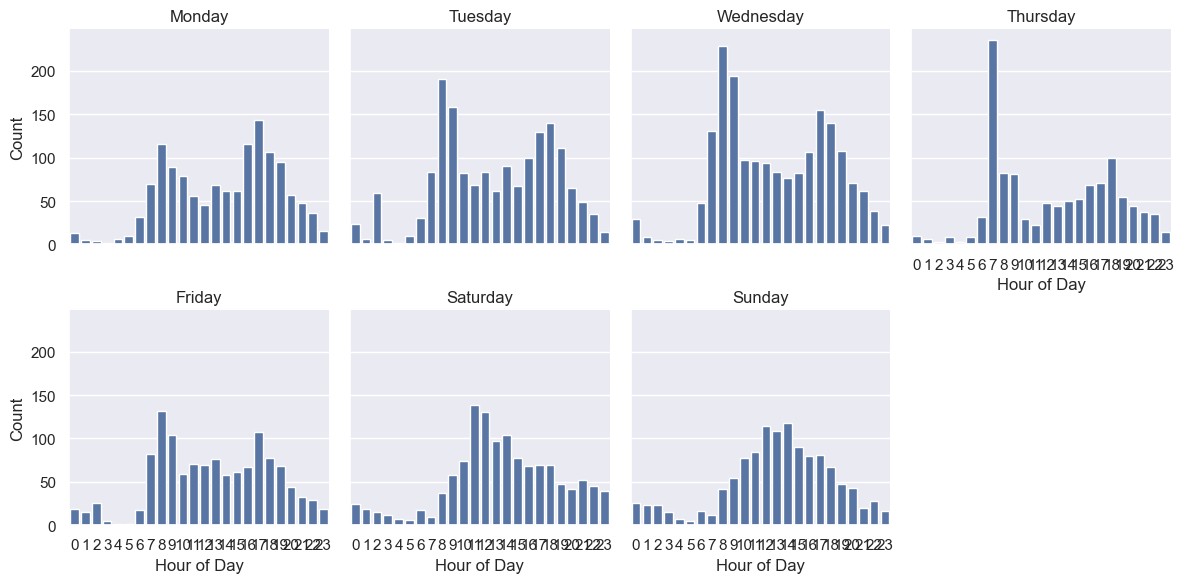

In [13]:
# Assuming you have already created the 'dow' and 'hour' columns in bike_trips
bike_trips['dow'] = bike_trips.trip_start_time.dt.day_name()
bike_trips['hour'] = bike_trips.trip_start_time.dt.hour

# Specify the order of days
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by 'dow' and 'hour' and count the occurrences
day_hour_counts = bike_trips.groupby(['dow', 'hour']).hour.count().reset_index(name='day_hour_count')

# Create a FacetGrid with the specified order of days
ax = sns.FacetGrid(data=day_hour_counts, col='dow', col_order=order, col_wrap=4)

# Use barplot with explicit order parameter
ax.map(sns.barplot, 'hour', 'day_hour_count', order=range(24))

# Set axis labels and plot title
ax.set_axis_labels('Hour of Day', 'Count')
ax.set_titles(col_template="{col_name}")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


### Predict

In [14]:
daily = bike_trips.set_index('trip_start_time').groupby(pd.Grouper(freq='D')).size()
daily = pd.DataFrame(daily)
daily = daily.reset_index()
daily.columns = ['ds', 'y']
daily.head()

,ds,y
0,2019-03-11,312
1,2019-03-12,543
2,2019-03-13,566
3,2019-03-14,439
4,2019-03-15,513


In [17]:
m = Prophet()
m.fit(daily)

16:07:34 - cmdstanpy - INFO - Chain [1] start processing
16:07:35 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future = m.make_future_dataframe(periods=5)
future.tail()

,ds
17,2019-03-28
18,2019-03-29
19,2019-03-30
20,2019-03-31
21,2019-04-01


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.to_pickle('forecast.pkl')

/opt/anaconda3/envs/rw_ml_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/rw_ml_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


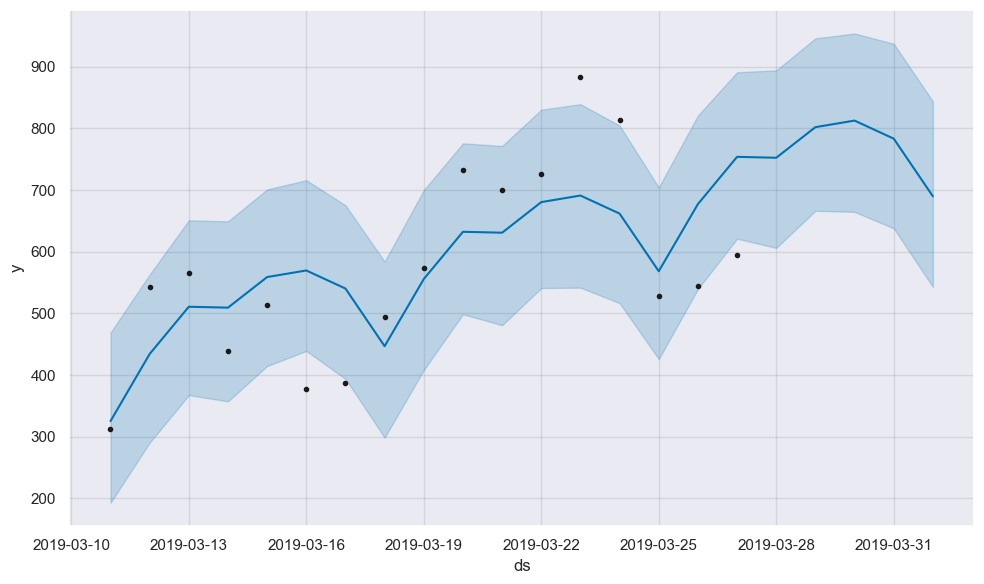

In [20]:
fig1 = m.plot(forecast)

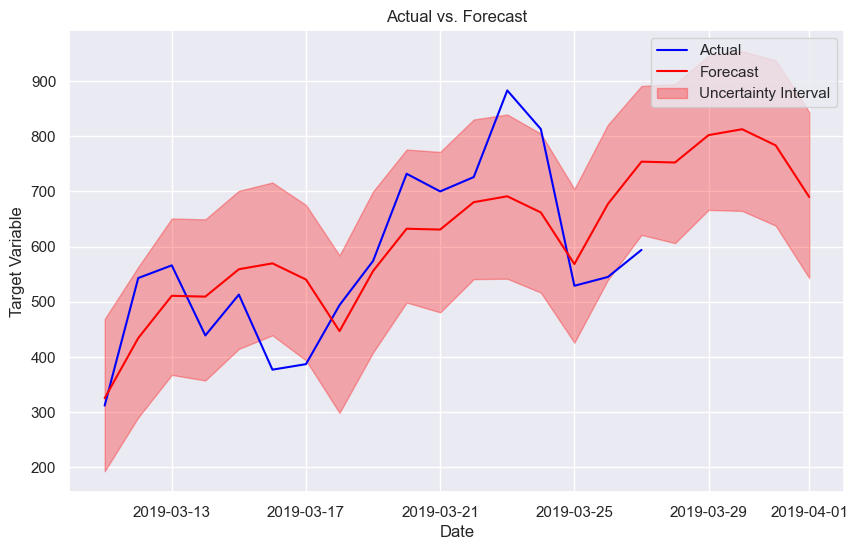

In [31]:
# Suppress FutureWarnings from the prophet library
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting the actuals and forecast
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual data
ax.plot(daily['ds'], daily['y'], label='Actual', color='blue')

# Plot the forecast
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')

# Plot uncertainty intervals if available
if 'yhat_lower' in forecast.columns and 'yhat_upper' in forecast.columns:
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.3, label='Uncertainty Interval')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Target Variable')
ax.set_title('Actual vs. Forecast')

# Show legend
ax.legend()

# Show the plot
plt.show()


### Hourly

In [22]:
hourly = bike_trips.set_index('trip_start_time').groupby(pd.Grouper(freq='2h')).size()
hourly = pd.DataFrame(hourly)
hourly = hourly.reset_index()
hourly.columns = ['ds', 'y']
hourly.head()

,ds,y
0,2019-03-11 08:00:00,47
1,2019-03-11 10:00:00,40
2,2019-03-11 12:00:00,25
3,2019-03-11 14:00:00,42
4,2019-03-11 16:00:00,79


In [23]:
mh = Prophet()
mh.fit(hourly)

16:18:05 - cmdstanpy - INFO - Chain [1] start processing


16:18:05 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
futureh = mh.make_future_dataframe(periods=120)
futureh.tail()

,ds
315,2019-07-21 22:00:00
316,2019-07-22 22:00:00
317,2019-07-23 22:00:00
318,2019-07-24 22:00:00
319,2019-07-25 22:00:00


In [25]:
forecasth = mh.predict(future)
forecasth[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
17,2019-03-28,33.950752,-4.664259,71.334618
18,2019-03-29,34.610110,-2.646549,75.978389
19,2019-03-30,36.451550,-2.165685,73.730993
20,2019-03-31,38.945768,0.539230,77.868651
21,2019-04-01,30.515905,-8.999408,71.018874


In [26]:
forecasth.to_pickle('forecast_hourly.pkl')

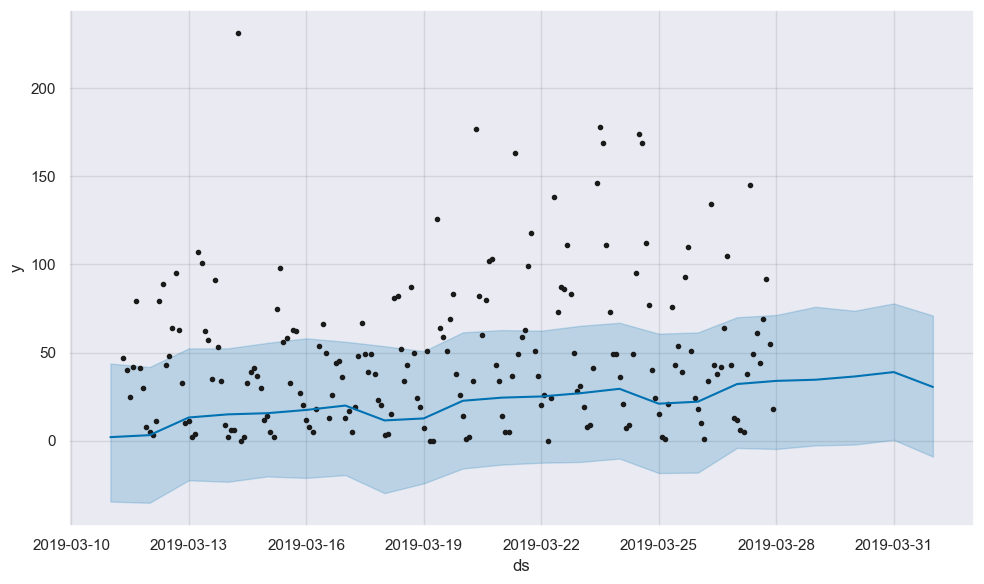

In [27]:
figh = mh.plot(forecasth)

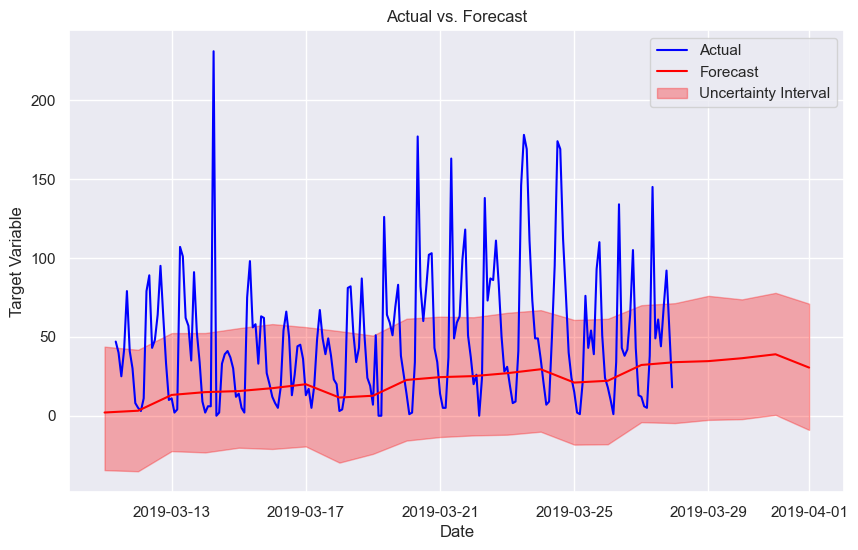

In [35]:
# Plotting the actuals and forecast
figh, axh = plt.subplots(figsize=(10, 6))

# Plot actual data
axh.plot(hourly['ds'], hourly['y'], label='Actual', color='blue')

# Plot the forecast
axh.plot(forecasth['ds'], forecasth['yhat'], label='Forecast', color='red')

# Plot uncertainty intervals if available
if 'yhat_lower' in forecasth.columns and 'yhat_upper' in forecast.columns:
    axh.fill_between(forecasth['ds'], forecasth['yhat_lower'], forecasth['yhat_upper'], color='red', alpha=0.3, label='Uncertainty Interval')

# Set labels and title
axh.set_xlabel('Date')
axh.set_ylabel('Target Variable')
axh.set_title('Actual vs. Forecast')

# Show legend
axh.legend()

# Show the plot
plt.show()
